# 📁 第一步：安裝與載入套件


In [ ]:
# pip install -q torchvision timm

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import timm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# 📁 第二步：下載 Oxford Pets 資料集（貓與狗）

In [ ]:
# 自動下載 & 解壓縮
dataset = torchvision.datasets.OxfordIIITPet(
    root="./data",
    download=True,
    transform=None
)

100%|██████████| 792M/792M [00:37<00:00, 21.3MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.0MB/s]


In [3]:
print(f"✅ 品種數量：{len(dataset.classes)}")
print(f"📋 前10種：{dataset.classes[:10]}")
print(dataset.class_to_idx)  # 品種名 → 數字 label 對應

✅ 品種數量：37
📋 前10種：['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair']
{'Abyssinian': 0, 'American Bulldog': 1, 'American Pit Bull Terrier': 2, 'Basset Hound': 3, 'Beagle': 4, 'Bengal': 5, 'Birman': 6, 'Bombay': 7, 'Boxer': 8, 'British Shorthair': 9, 'Chihuahua': 10, 'Egyptian Mau': 11, 'English Cocker Spaniel': 12, 'English Setter': 13, 'German Shorthaired': 14, 'Great Pyrenees': 15, 'Havanese': 16, 'Japanese Chin': 17, 'Keeshond': 18, 'Leonberger': 19, 'Maine Coon': 20, 'Miniature Pinscher': 21, 'Newfoundland': 22, 'Persian': 23, 'Pomeranian': 24, 'Pug': 25, 'Ragdoll': 26, 'Russian Blue': 27, 'Saint Bernard': 28, 'Samoyed': 29, 'Scottish Terrier': 30, 'Shiba Inu': 31, 'Siamese': 32, 'Sphynx': 33, 'Staffordshire Bull Terrier': 34, 'Wheaten Terrier': 35, 'Yorkshire Terrier': 36}


# 📁 第三步：資料切分 & 載入器（DataLoader）

In [4]:
# 定義 transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# 固定隨機種子來切分 train/val
generator = torch.Generator().manual_seed(69)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_indices, val_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, val_size], generator=generator)

In [6]:
# 自定義 Subset 類別以支援不同 transform
class TransformSubset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label


In [7]:
# 應用 transforms
train_dataset = TransformSubset(dataset, train_indices.indices, train_transform)
val_dataset = TransformSubset(dataset, val_indices.indices, val_transform)

# 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

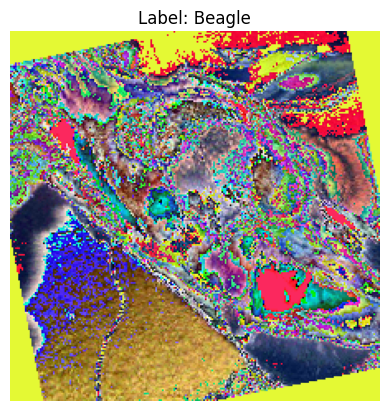

In [8]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# 取一筆資料（image 是 Tensor, label 是 int）
image, label = train_dataset[0]
predicted_breed = dataset.classes[label]

# 如果圖像是 Tensor，要轉回 PIL 或 numpy 才能顯示
if isinstance(image, torch.Tensor):
    image = F.to_pil_image(image)  # 轉為 PIL 圖片

# 顯示圖片和標籤
plt.imshow(image)
plt.title(f"Label: {predicted_breed}")
plt.axis('off')
plt.show()

# 📁 第四步：使用預訓練CNN模型（ResNet18）進行微調

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  # !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [11]:
model = models.resnet18(pretrained=True)
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
  input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
  # col_names=["input_size"], # uncomment for smaller output
  col_names=["input_size", "output_size", "num_params", "trainable"],
  col_width=20,
  row_settings=["var_names"]
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [12]:
import torch.nn as nn
# 替換最後一層
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # 原本 0.2 改成 0.3 嘗試減少過擬合
    nn.Linear(model.fc.in_features, len(dataset.classes))
)
model = model.to(device)

In [13]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
    input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 37]             --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

# 📁 第五步：訓練模型

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

torch.manual_seed(42)

In [ ]:
from tqdm.auto import tqdm

# 假設你已經有這些變數：
# model, train_loader, val_loader, device

# 最佳模型的初始準確率（為了儲存最佳模型用）
best_acc = 0.0

# 訓練迴圈
for epoch in range(10):  # 可先設定為 5 輪，之後增加
    model.train()
    running_loss = 0.0

    # 訓練每一批
    for images, labels in tqdm(train_loader, desc=f"[訓練 Epoch {epoch+1}]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 訓練平均損失
    avg_train_loss = running_loss / len(train_loader)

    # 驗證模型
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total

    print(f"\n📘 Epoch {epoch+1} 結果:")
    print(f"🧠 訓練損失: {avg_train_loss:.4f}")
    print(f"✅ 驗證損失: {avg_val_loss:.4f}")
    print(f"🎯 驗證準確率: {val_acc:.4f}")

    # 如果這次驗證比較好，就存下模型
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 儲存最佳模型 ✅")
    else:
        torch.save(model.state_dict(), "model.pth")
        print("💾 儲存最新模型 ✅")

print(f"\n🎉 訓練完成！最佳驗證準確率: {best_acc:.4f}")


[訓練 Epoch 1]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 1 結果:
🧠 訓練損失: 1.9428
✅ 驗證損失: 1.0217
🎯 驗證準確率: 0.6916
💾 儲存最佳模型 ✅


[訓練 Epoch 2]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 2 結果:
🧠 訓練損失: 1.2747
✅ 驗證損失: 1.2010
🎯 驗證準確率: 0.6508
💾 儲存最新模型 ✅


[訓練 Epoch 3]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 3 結果:
🧠 訓練損失: 1.1190
✅ 驗證損失: 1.0531
🎯 驗證準確率: 0.6739
💾 儲存最新模型 ✅


[訓練 Epoch 4]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 4 結果:
🧠 訓練損失: 1.0727
✅ 驗證損失: 0.8602
🎯 驗證準確率: 0.7079
💾 儲存最佳模型 ✅


[訓練 Epoch 5]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 5 結果:
🧠 訓練損失: 0.9998
✅ 驗證損失: 1.1296
🎯 驗證準確率: 0.6603
💾 儲存最新模型 ✅


[訓練 Epoch 6]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 6 結果:
🧠 訓練損失: 0.9288
✅ 驗證損失: 0.7897
🎯 驗證準確率: 0.7609
💾 儲存最佳模型 ✅


[訓練 Epoch 7]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 7 結果:
🧠 訓練損失: 0.9156
✅ 驗證損失: 0.8889
🎯 驗證準確率: 0.7283
💾 儲存最新模型 ✅


[訓練 Epoch 8]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 8 結果:
🧠 訓練損失: 0.8169
✅ 驗證損失: 0.6040
🎯 驗證準確率: 0.8152
💾 儲存最佳模型 ✅


[訓練 Epoch 9]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 9 結果:
🧠 訓練損失: 0.8719
✅ 驗證損失: 1.0868
🎯 驗證準確率: 0.7215
💾 儲存最新模型 ✅


[訓練 Epoch 10]:   0%|          | 0/92 [00:00<?, ?it/s]


📘 Epoch 10 結果:
🧠 訓練損失: 0.7446
✅ 驗證損失: 0.5829
🎯 驗證準確率: 0.8234
💾 儲存最佳模型 ✅

🎉 訓練完成！最佳驗證準確率: 0.8234


# 📁 第六步：收集「被錯誤辨識為狗」的貓

In [22]:
# 所有 Oxford-IIIT Pet 的品種名（共 37 個）
breeds = sorted(list(set(['_'.join(name.split('_')[:-1]) for name in os.listdir('./data/oxford-iiit-pet/images') if name.endswith('.jpg')])))

# 貓咪品種清單（共 12 種）
cat_breeds = [
    'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
    'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
    'Siamese', 'Sphynx'
]

# 建立映射
breed_to_idx = {breed: i for i, breed in enumerate(breeds)}
idx_to_breed = {i: breed for i, breed in enumerate(breeds)}


In [23]:
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

model.eval()
misclassified_cats = defaultdict(list)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        topk_vals, topk_idxs = torch.topk(outputs, k=3, dim=1)  # 取前3名
        for i in range(len(images)):
            true_class = dataset.classes[labels[i].item()]
            top3_classes = [dataset.classes[idx.item()] for idx in topk_idxs[i]]
            is_true_cat = true_class in cat_breeds
            top3_has_cat = any(c in cat_breeds for c in top3_classes)

            if is_true_cat and not top3_has_cat:
                # 真的是貓，預測前3都不是貓 => 真正的貓變狗
                misclassified_cats[true_class].append((images[i].cpu(), top3_classes))


🐱 真實類別: Birman 被誤判為（Top‑3 都是狗）:
  🔺 Top3: ['Keeshond', 'Leonberger', 'Shiba Inu']


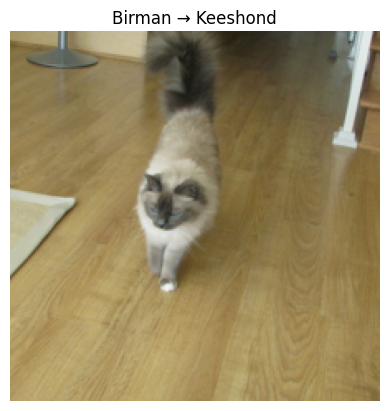


🐱 真實類別: Abyssinian 被誤判為（Top‑3 都是狗）:
  🔺 Top3: ['English Cocker Spaniel', 'Scottish Terrier', 'Havanese']


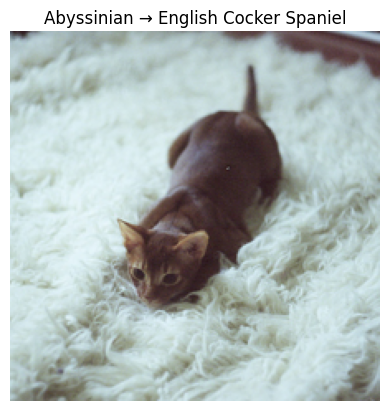

In [24]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

for true_cat in misclassified_cats:
    print(f"\n🐱 真實類別: {true_cat} 被誤判為（Top‑3 都是狗）:")
    shown = 0
    for img, top3 in misclassified_cats[true_cat]:
        print(f"  🔺 Top3: {top3}")
        plt.imshow(np.transpose(unnormalize(img).numpy(), (1, 2, 0)))
        plt.title(f"{true_cat} → {top3[0]}")
        plt.axis("off")
        plt.show()
        shown += 1
        if shown >= 2:
            break


In [25]:
# 依照誤判數排序
misclassified_count = {k: len(v) for k, v in misclassified_cats.items()}
sorted_misclassified = sorted(misclassified_count.items(), key=lambda x: x[1], reverse=True)

print("🔢 誤判為狗最多的前幾名貓品種：")
for i, (breed, count) in enumerate(sorted_misclassified[:5]):
    print(f"{i+1}. {breed}：{count} 次")


🔢 誤判為狗最多的前幾名貓品種：
1. Birman：1 次
2. Abyssinian：1 次


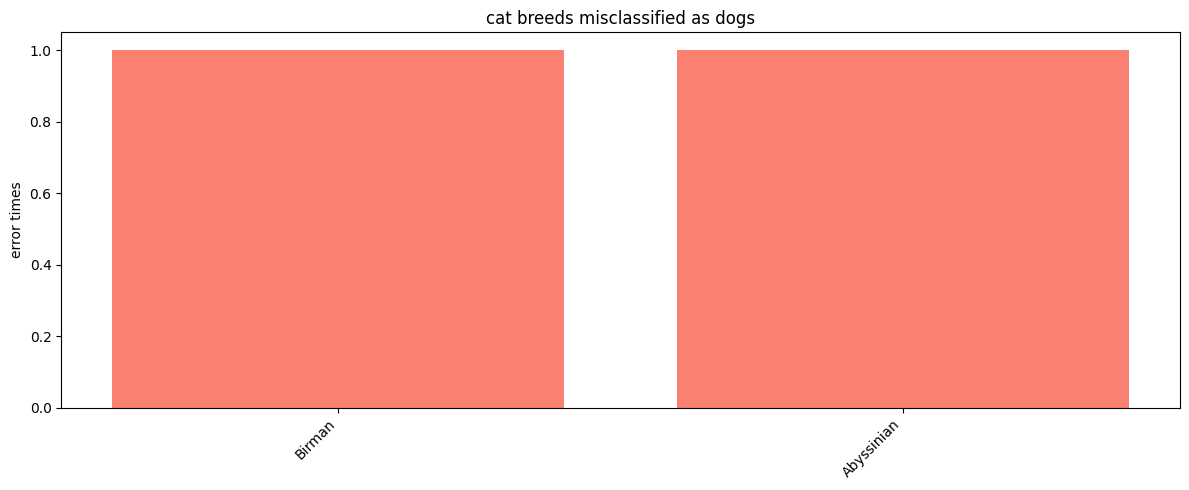

In [26]:
import matplotlib.pyplot as plt

labels = [item[0] for item in sorted_misclassified]
counts = [item[1] for item in sorted_misclassified]

plt.figure(figsize=(12, 5))
plt.bar(labels, counts, color='salmon')
plt.title("cat breeds misclassified as dogs")
plt.ylabel("error times")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

# 確保鍵存在
if 'Russian_Blue' in misclassified_cats:
    print(f"共 {len(misclassified_cats['Russian_Blue'])} 張 Russian Blue 被誤判為狗")

    for i, (img, wrong_label) in enumerate(misclassified_cats['Russian_Blue']):
        img = unnormalize(img)
        plt.figure(figsize=(3, 3))
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(f"🐱 Russian_Blue → dog {wrong_label}")
        plt.axis("off")
        plt.show()
else:
    print("Russian_Blue 沒有被誤判為狗")


Russian_Blue 沒有被誤判為狗


# 統計

In [32]:
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet(root=".", download=True)
print(f"📦 圖片總數：{len(dataset)}")


100%|██████████| 792M/792M [00:33<00:00, 23.8MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 8.78MB/s]


📦 圖片總數：3680


In [30]:
print("\n🔢 各貓品種統計（含實際圖片數量）:")
print(f"{'貓品種':<20} {'總圖數':>6} {'誤判次數':>8} {'誤判率':>10}")
print("-" * 45)

for breed in sorted(total_cat_counts.keys()):
    total = total_cat_counts[breed]
    wrong = misclassified_counts.get(breed, 0)
    rate = wrong / total if total > 0 else 0
    print(f"{breed:<20} {total:>6} {wrong:>8} {rate:>9.2%}")



🔢 各貓品種統計（含實際圖片數量）:
貓品種                     總圖數     誤判次數        誤判率
---------------------------------------------
Abyssinian               20        1     5.00%
Bengal                   15        0     0.00%
Birman                   17        1     5.88%
Bombay                   21        0     0.00%
Persian                  18        0     0.00%
Ragdoll                  24        0     0.00%
Siamese                  22        0     0.00%
Sphynx                   20        0     0.00%
